In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATASETS
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE CELL.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote
from urllib.error import HTTPError
from zipfile import ZipFile

CHUNK_SIZE = 40960 
DATASET_MAPPING = 'riiid-test-answer-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F21651%2F1595136%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20201227%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20201227T210321Z%26X-Goog-Expires%3D259199%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D141dfd2ead959af802b269f08a97e096dac3ea9d2db70ad9047478df0432aa5115f01ca84f08d7079b8f95c4beb098ab30a4433fe531c4a987fcd3ee01a1a432676412f67ba666b7691d2345236530006a9e9348c5bd9efdb122831457f0b32ebe76adc2fdf1763d1067ef7647c53705fd002b546bed33a2325ed7d01c939fd519452cb286f41cc81d539c2e5bfe0e3f4efae0f8e0fe7a146f4a2cbd94e4bb1d9dfee1ba5e6357162a874be9862af23bb92af914c549e08fd393970ba8f725a4afc3f124720742deb52564ee9c3f29d8180771853c1b0f21db00d9bede834eedcd85f14cfe65bdba9c4f1c66f70c39c7169542ff1247b1e3ed87f6a6d9d13899'
KAGGLE_INPUT_PATH='/home/kaggle/input'
KAGGLE_INPUT_SYMLINK='/kaggle'

os.makedirs(KAGGLE_INPUT_PATH, 777)
os.symlink(KAGGLE_INPUT_PATH, os.path.join('..', 'input'), target_is_directory=True)
os.makedirs(KAGGLE_INPUT_SYMLINK)
os.symlink(KAGGLE_INPUT_PATH, os.path.join(KAGGLE_INPUT_SYMLINK, 'input'), target_is_directory=True)

for dataset_mapping in DATASET_MAPPING.split(','):
    directory, download_url_encoded = dataset_mapping.split(':')
    download_url = unquote(download_url_encoded)
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as zipfileres, NamedTemporaryFile() as tfile:
            total_length = zipfileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes zipped')
            dl = 0
            data = zipfileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = zipfileres.read(CHUNK_SIZE)
            print(f'\nUnzipping {directory}')
            with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue
print('Dataset import complete.')


[==================================================] 1386476890 bytes downloaded
Unzipping riiid-test-answer-prediction
Dataset import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so


In [3]:
#lod required packages
import lightgbm as lgb
import sklearn
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn import preprocessing
import numpy as np
from sklearn.impute import SimpleImputer
from collections import Counter



In [28]:
traindf = pd.read_csv("/kaggle/input/riiid-test-answer-prediction/train.csv")
traindf = traindf[(traindf['user_id']<400000000)]


In [29]:
trainA = traindf[["content_id","answered_correctly"]].groupby("content_id").mean()
trainA = trainA.rename(columns={'answered_correctly':'average_correct_content'})

In [30]:
trainB = traindf[["user_id","answered_correctly"]].groupby("user_id").mean()
trainB = trainB.rename(columns={'answered_correctly':'average_correct_user_id'})
trainC = traindf[["user_id","answered_correctly"]].groupby("user_id").sum()
trainC = trainC.rename(columns={'answered_correctly':'Total_correct_user_id'})

In [31]:
traindf["AnsweredInARow"]=traindf[["row_id","user_id","answered_correctly"]].groupby(["user_id",(traindf['answered_correctly']==0).cumsum()]).cumcount()-1

In [32]:
traindf["AnsweredInARow"]=np.where(traindf['AnsweredInARow']== -1,0,traindf["AnsweredInARow"])

In [33]:
trainA['average_correct_content'] = np.where(trainA['average_correct_content']<0,0,trainA['average_correct_content'])
trainA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13768 entries, 0 to 32736
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   average_correct_content  13768 non-null  float64
dtypes: float64(1)
memory usage: 215.1 KB


In [34]:
#join the features
traindf = traindf.merge(trainA, on ="content_id", how="left")

In [35]:
traindf = traindf.merge(trainB, on="user_id", how="left")
traindf = traindf.merge(trainC, on="user_id", how="left")

In [36]:
trainD = traindf[['user_id','row_id','timestamp','prior_question_elapsed_time']]

In [37]:
trainD = trainD.sort_values(['user_id','timestamp'])

In [38]:
trainD['timebetween'] = trainD.groupby('user_id')['timestamp'].diff()
trainD['lag'] = trainD['timebetween']-trainD['prior_question_elapsed_time']
traindf = traindf.sort_values(['row_id'])

In [39]:
del (trainA,trainB,trainC) # clear some mem
gc.collect()

22

In [40]:
traindf = traindf.merge(trainD[['row_id','timebetween','lag']],on='row_id',how='left')

In [41]:
trainE = traindf[['user_id','user_answer']].groupby(['user_id','user_answer'])['user_answer'].count()
trainE=trainE.to_frame()
trainE['user_answer_count'] = trainE['user_answer']
trainE = trainE.drop(['user_answer'], axis=1)
trainE =trainE.reset_index()
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18604119 entries, 0 to 18604118
Data columns (total 16 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
 10  AnsweredInARow                  int64  
 11  average_correct_content         float64
 12  average_correct_user_id         float64
 13  Total_correct_user_id           int64  
 14  timebetween                     float64
 15  lag                             float64
dtypes: float64(5), int64(10), object(1)
memory usage: 2.4+ GB


In [42]:
dummie  = trainE.pivot(index='user_id', columns ='user_answer', values ='user_answer_count')
dummie=dummie.reset_index()
dummie=dummie.rename(columns = {-1:"User_answer_-1", 0:"User_answer_0", 1:"User_answer_1",2:"User_answer_2",3:"User_answer_3"})
dummie=dummie.fillna(0)
dummie['total'] = dummie['User_answer_-1']+dummie['User_answer_0']+dummie['User_answer_1']+dummie['User_answer_2']+dummie['User_answer_2']+dummie['User_answer_3']

for col in dummie.columns[1:6]:
    dummie[col] = dummie[col]/dummie['total']*100
    dummie[col] = dummie[col].round(1)
    
dummie=dummie.drop(['total'], axis=1)
# df_dummies = pd.get_dummies(trainE, columns =['user_answer'])

# for col in df_dummies.columns[3:]:
#     df_dummies[col] = df_dummies[col]*df_dummies['user_answer_count']

In [43]:
dummie.head()


user_answer,user_id,User_answer_-1,User_answer_0,User_answer_1,User_answer_2,User_answer_3
0,115,0.0,19.3,19.3,19.3,22.8
1,124,0.0,18.4,15.8,21.1,23.7
2,2746,5.0,35.0,10.0,0.0,50.0
3,5382,2.1,27.1,24.3,11.1,24.3
4,8623,2.4,26.8,22.8,11.8,24.4


In [44]:
traindf=traindf.merge(dummie,on=['user_id'], how='left')
# remove answered correctly =-1 or your metrics won't work
traindf['answered_correctly'] = np.where(traindf['answered_correctly']<0,0,traindf['answered_correctly'])
#remove nan's from data frame
#traindf=traindf.dropna() # do not drop na, at least for lightgbm as it can handle them.. e.g. na's could become break points
#make prior question had explination a category in integer form
#traindf['prior_question_had_explanation'] = np.where(traindf['prior_question_had_explanation']=='True',1,0)-this did not add value to model, removing 


In [45]:
#pull in lecture data
lecture = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
lecture=lecture.rename(columns={'lecture_id':'content_id'})
dummy = pd.get_dummies(lecture['type_of'])
lecture = pd.concat([lecture,dummy], axis=1)
lecture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   content_id        418 non-null    int64 
 1   tag               418 non-null    int64 
 2   part              418 non-null    int64 
 3   type_of           418 non-null    object
 4   concept           418 non-null    uint8 
 5   intention         418 non-null    uint8 
 6   solving question  418 non-null    uint8 
 7   starter           418 non-null    uint8 
dtypes: int64(3), object(1), uint8(4)
memory usage: 14.8+ KB


In [46]:
traindf = traindf.merge(lecture, on="content_id", how='left')

In [47]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18604119 entries, 0 to 18604118
Data columns (total 28 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
 10  AnsweredInARow                  int64  
 11  average_correct_content         float64
 12  average_correct_user_id         float64
 13  Total_correct_user_id           int64  
 14  timebetween                     float64
 15  lag                             float64
 16  User_answer_-1                  float64
 17  User_answer_0            

In [48]:
# #train lightgbm
TrainX = traindf.drop(["answered_correctly"], axis=1)
TrainY = traindf['answered_correctly']
del(traindf)
gc.collect()
import random
random.seed(100)
(X_train, X_test, y_train, y_test) = train_test_split(TrainX, TrainY) #create␣train and test set

In [49]:
# choose the variables needed
X_train = X_train.drop(['Total_correct_user_id','content_id','type_of','user_answer','prior_question_had_explanation','task_container_id','content_type_id','row_id','timestamp','user_id','part','tag'],axis=1)
X_test = X_test.drop(['Total_correct_user_id','content_id','type_of','user_answer','prior_question_had_explanation','task_container_id','content_type_id','row_id','timestamp','user_id','part','tag'],axis=1)

In [50]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13953089 entries, 9056571 to 3051376
Data columns (total 15 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   prior_question_elapsed_time  float64
 1   AnsweredInARow               int64  
 2   average_correct_content      float64
 3   average_correct_user_id      float64
 4   timebetween                  float64
 5   lag                          float64
 6   User_answer_-1               float64
 7   User_answer_0                float64
 8   User_answer_1                float64
 9   User_answer_2                float64
 10  User_answer_3                float64
 11  concept                      float64
 12  intention                    float64
 13  solving question             float64
 14  starter                      float64
dtypes: float64(14), int64(1)
memory usage: 1.7 GB


In [51]:
train_lgb = lgb.Dataset(X_train, label=y_train)
train_validation = lgb.Dataset(X_test, label=y_test)
num111=len(y_train) # number of rows
w = np.random.rand(num111,)
train_lgb.set_weight(w)
param = params = {'boosting_type': 'goss',
          'max_depth' :-1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 60,
          'learning_rate': 0.02,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 30,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }


[4]	training's auc: 0.915256
[8]	training's auc: 0.918985
[12]	training's auc: 0.919952
[16]	training's auc: 0.920191
[20]	training's auc: 0.920253
[24]	training's auc: 0.920251
[28]	training's auc: 0.920363
[32]	training's auc: 0.920468
[36]	training's auc: 0.920509
[40]	training's auc: 0.92055
[44]	training's auc: 0.920663
[48]	training's auc: 0.920696
[52]	training's auc: 0.920716
[56]	training's auc: 0.920743
[60]	training's auc: 0.920781
[64]	training's auc: 0.920794
[68]	training's auc: 0.920831
[72]	training's auc: 0.920868
[76]	training's auc: 0.920975
[80]	training's auc: 0.920992
[84]	training's auc: 0.921036
[88]	training's auc: 0.92108
[92]	training's auc: 0.921129
[96]	training's auc: 0.921176
[100]	training's auc: 0.921213
[104]	training's auc: 0.921247
[108]	training's auc: 0.9213
[112]	training's auc: 0.921345
[116]	training's auc: 0.921377
[120]	training's auc: 0.921423
[124]	training's auc: 0.921444


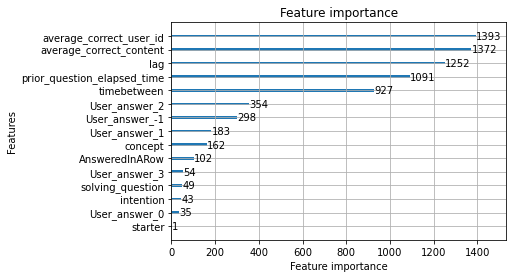

In [52]:
#run model
model = lgb.train(param,train_lgb, 124, verbose_eval=4,valid_sets=[train_lgb])
tree_imp = lgb.plot_importance(model)
y_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_pred = np.round_(y_pred, 0)

In [53]:
y_pred1 = model.predict(X_test, num_iteration=model.best_iteration)
y_pred1 = np.round_(y_pred1,0)
y_pred1[1:50]

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.])

In [68]:
from collections import Counter
Counter(y_train)



In [55]:
y = np.array(y_test)
pred = np.array(y_pred1)
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.846417659264863

In [69]:
#prep for logistic and SVM
names = ['concept','intention','solving question','starter']

for i in names:#make sure categorical varibles give 1 if instance is known otherwise 0 if neg or unknown
    X_train[i] = X_train[i].fillna(0)
    X_test[i]  = X_test[i].fillna(0)
    
X_test = X_test.fillna(X_test.mean()) # deal with na's to fit in logistic regression
X_train = X_train.fillna(X_train.mean()) # deal with na's to fit in logistic regression

In [70]:
#third model decision by comittee, logistic regression
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
logit_model = sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.379682
         Iterations 10
                               Results: Logit
Model:                 Logit                Pseudo R-squared:   0.416        
Dependent Variable:    answered_correctly   AIC:                10595476.8939
Date:                  2020-12-25 20:46     BIC:                10595592.5036
No. Observations:      13953089             Log-Likelihood:     -5.2977e+06  
Df Model:              7                    LL-Null:            -9.0767e+06  
Df Residuals:          13953081             LLR p-value:        0.0000       
Converged:             1.0000               Scale:              1.0000       
No. Iterations:        10.0000                                               
-----------------------------------------------------------------------------
                             Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------

In [71]:
predlogreg=result.predict(X_test)
y_predlog = np.round_(predlogreg, 0)

In [72]:
y = np.array(y_test)
pred = np.array(y_predlog)
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.8143211005124248

In [61]:
#--for future analysis if time allows--
# grid = GridSearchCV(model, gridParams, verbose=2, cv=4, n_jobs=-1)
# # Run the grid
# grid.fit(X_train.drop(['user_answer','prior_question_had_explanation','task_container_id','content_id','content_type_id','row_id','timestamp','user_id'],axis=1), y_train)
# print(grid.best_params_)
# print(grid.best_score_)

In [ ]:
#--for future analysis if time allows
# params['colsample_bytree'] = grid.best_params_['colsample_bytree']
# params['learning_rate'] = grid.best_params_['learning_rate']
# # params['max_bin'] = grid.best_params_['max_bin']
# params['num_leaves'] = grid.best_params_['num_leaves']
# #params['reg_alpha'] = grid.best_params_['reg_alpha']
# #params['reg_lambda'] = grid.best_params_['reg_lambda']
# params['subsample'] = grid.best_params_['subsample']
# # params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

# print('Fitting with params: ')
# print(params)

In [73]:
from sklearn import svm

In [74]:
import numpy as np
from sklearn.impute import SimpleImputer

In [75]:
from sklearn.preprocessing import MinMaxScaler # reduce boundry space spare the machine
scaling = MinMaxScaler()
X_train = scaling.fit_transform(X_train)
X_test = scaling.fit_transform(X_test)

In [76]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [77]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13953089 entries, 0 to 13953088
Data columns (total 15 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
dtypes: float64(15)
memory usage: 1.6 GB


In [78]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC()

In [79]:
y_pred2=clf.predict(X_test)

In [80]:
y_pred2[1:50]

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1], dtype=int64)

In [81]:
y = np.array(y_test)
pred = np.array(y_pred2)
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.7919527322177152

In [82]:
#composite score..
dataset = pd.DataFrame({'svm': y_pred2, 'log': y_predlog, 'lightgbm':y_pred1}, columns=['svm', 'log','lightgbm'])
dataset['composite']  = dataset['svm'] + dataset['log'] + dataset['lightgbm']
composite = np.round_(dataset['composite'],0)
y = np.array(y_test)
pred = np.array(composite)
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.8577098674271479

In [265]:
dataset.head()

,svm,log,lightgbm
14562842,0,0.0,0.0
4058658,1,1.0,1.0
898362,0,0.0,0.0
8139358,1,1.0,0.0
11726116,0,0.0,0.0


In [ ]:
# create composite model
#SEQUENCE OF TAGS.... 